<a href="https://colab.research.google.com/github/anasben7/deepTweets/blob/main/deep_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


# Using Logistic Regression

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
stem = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# read the train and test file
df = pd.read_csv("/content/MyDrive/MyDrive/Colab Notebooks/data/deep_tweets/train.csv")
df_test_original = pd.read_csv("/content/MyDrive/MyDrive/Colab Notebooks/data/deep_tweets/test.csv")  
df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


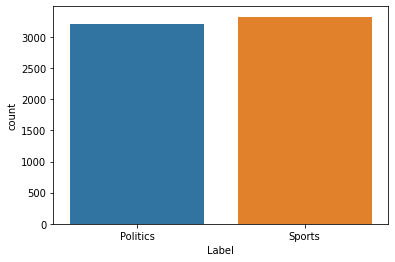

In [6]:
# visualizing the two labels by the number of tweets
import seaborn as sns
sns.countplot(x='Label', data=df)

In [11]:
df.drop('TweetId',axis = 1,inplace = True)
# we will use this later on to create the submission.csv file
test_TweetId = df_test_original['TweetId'].values

In [12]:
#Encoding the labels : 1 for Sports and 0 for Politics
y = df["Label"]
y = np.array(list(map(lambda x: 1 if x=="Sports" else 0, y)))
x = df["TweetText"].to_list()

In [13]:
#Removing stop words with NLTK, the punctuation marks and terms like RT and via
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

#Function to clean our Data
def clean_data(x):
    texts = []
    for sen in range(0, len(x)):
        text = re.sub(r'\W', ' ', str(x[sen]))
        text = re.sub(r'http\S+|www.\S+', '', text)
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  
        text = re.sub(r"\d","",text)
        text = re.sub(r"\n","",text)
        text = re.sub(r'[^\w\s]','',text)       
        text = re.sub(r'[^\x00-\x7f]',r' ',text)
        text = text.lower()
        text = text.split()
        text = [stem.lemmatize(word) for word in text]
        text = ' '.join([w for w in text if w not in stop])
        texts.append(text)
    return texts

In [14]:
x = clean_data(x)
df_test = df_test_original.copy()
x_test = clean_data(df_test['TweetText'].to_list())

In [15]:
vectorizer = CountVectorizer(max_features=1067, min_df=5, 
                             max_df=0.7, stop_words=stopwords.words('english'))
x = vectorizer.fit_transform(x).toarray()
tfidfconverter = TfidfTransformer()
x = tfidfconverter.fit_transform(x).toarray()

In [16]:
# Divide dataset into train and test data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)

In [17]:
class LogisticRegression(object):
  """Logistic Regression classifier.
    Parameters
    ----------
    n_iter : int, default 1000
        number of iterations the gradient descent should process
    eta : int, default 0.1
        the learning rate.
        High learning rate: might overshoot the minimum
        Low learning rate: gradient descent could take too long (does not reach minimum within n_iter)
    Attributes
    ----------
    weights : array, shape(n_features, )
        Coefficients for the hypothesis. The weights will be 'fitted' during the gradient descent
    costs_per_iter : array, shape(n_iter, )
        Contains the sum of costs for every iteration
    """
  def __init__(self, eta=0.1, n_iter=1000):  
      self.eta = eta
      self.n_iter = n_iter
      self.weights = []
      self.costs_per_iter = []

  def fit(self, X, y):
    """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        Returns
        -------
        self : object
        """
    X = self.add_column_with_ones(X)  
    self.weights = np.zeros(X.shape[1])
    for _ in range(self.n_iter):
        # Gradient descent
        self.weights -= self.eta * np.dot(X.T, self.costs(X, y)) / len(y)
        # Append current costs (just for visualization purposes)
        self.costs_per_iter.append(np.absolute(self.costs(X, y)).sum())
            
  def costs(self, X, y):
      return self.hypothesis(X) - y

  def hypothesis(self, X):
      return 1 / (1 + np.exp(-np.dot(X, self.weights)))

  def predict(self, X):
      """
        Predict the target value(s)
        Parameters
        ----------
        X : numpy array, shape(m_samples, n_features)
            Data to use for prediction
        Returns
        -------
        prediction : numpy array, shape(m_samples, )
            Prediction for every sample in X
        """
    
      X = self.add_column_with_ones(X)
      return np.where(self.hypothesis(X) >= 0.5, 1, 0)

  def add_column_with_ones(self, X):
      # Add one column with ones (for weight_0, the 'bias')
      # Otherwise you have to calculate weight[0] and weight[1:] separately
      return np.concatenate([np.ones((len(X), 1)), X], axis=1)

In [18]:
# Instantiate a new LogisticRegression and call its fit-method with the train data
lr = LogisticRegression()
lr.fit(np.array(x_train), np.array(y_train))

In [19]:
# Predict the result with the validating data only
y_pred = lr.predict(x_valid)
print("Accuracy Score", accuracy_score(y_valid, y_pred))

Accuracy Score 0.8996168582375479


In [20]:
x_test = vectorizer.fit_transform(x_test).toarray()
x_test = tfidfconverter.fit_transform(x_test).toarray()

In [21]:
predictions = lr.predict(x_test)
predictions = np.array(list(map(lambda x: "Sports" if x==1 else "Politics", predictions)))

In [26]:
submission = {
    'TweetId': test_TweetId,
    'Label': predictions
}
results = pd.DataFrame(submission)
results.head(10)

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Sports
4,297941800658812928,Sports
5,305722428531802112,Politics
6,304713516256997377,Sports
7,234999630725783553,Sports
8,303712268372283392,Sports
9,304215754130194432,Sports


In [27]:
results.to_csv("submission.csv",index=False)

# Using Deep Learning CNN

In [ ]:
import numpy as np
import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
import requests
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
stem = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/MyDrive/MyDrive/Colab Notebooks/data/deep_tweets/train.csv")
df_test_original = pd.read_csv("/content/MyDrive/MyDrive/Colab Notebooks/data/deep_tweets/test.csv")
df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [ ]:
# visualizing the two labels by the number of tweets
import seaborn as sns
sns.countplot(x='Label', data=df)

In [ ]:
df.drop('TweetId',axis = 1,inplace = True)
# we will use this later on to create the submission.csv file
test_TweetId = df_test_original['TweetId'].values

In [ ]:
#Encoding the labels : 1 for Sports and 0 for Politics
y_train = df["Label"]
x = df["TweetText"].to_list()
y_train = np.array(list(map(lambda x: 1 if x=="Sports" else 0, y_train)))

In [ ]:
#Removing stop words with NLTK, the punctuation marks and terms like RT and via
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

#Function to clean our Data
def clean_data(x):
    texts = []
    for sen in range(0, len(x)):
        text = re.sub(r'\W', ' ', str(x[sen]))
        text = re.sub(r'http\S+|www.\S+', '', text)
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  
        text = re.sub(r"\d","",text)
        text = re.sub(r"\n","",text)
        text = re.sub(r'[^\w\s]','',text)       
        text = re.sub(r'[^\x00-\x7f]',r' ',text)
        text = text.lower()
        text = text.split()
        text = [stem.lemmatize(word) for word in text]
        text = ' '.join([w for w in text if w not in stop])
        texts.append(text)
    return texts

In [ ]:
x_train = clean_data(x)
df_test = df_test_original.copy()
x_test = clean_data(df_test['TweetText'].to_list())

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
import tensorflow as tf

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.2)
x_train = np.array(tokenizer.texts_to_sequences(x_train))
x_valid = np.array(tokenizer.texts_to_sequences(x_valid))
maxlen = 500
x_train = pad_sequences(x_train,padding="post",maxlen=maxlen)
x_valid = pad_sequences(x_valid,padding="post",maxlen=maxlen)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

y_train = np.asarray(tf.keras.utils.to_categorical(y_train))
y_valid = np.asarray(tf.keras.utils.to_categorical(y_valid))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import losses
max_features = 20000
embedding_dim = 64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1,embedding_dim,input_length=sequence_length,embeddings_regularizer=regularizers.l2(0.0005) ))
model.add(tf.keras.layers.Conv1D(128,3,activation='relu',kernel_regularizer=regularizers.l2(0.0005),bias_regularizer=regularizers.l2(0.0005)))
model.add(tf.keras.layers.Conv1D(150,2,activation='relu',kernel_regularizer=regularizers.l2(0.0005),bias_regularizer=regularizers.l2(0.0005)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l1(0.01)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 64)            1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 128)           24704     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 150)           38550     
_________________________________________________________________
global_max_pooling1d (Global (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 302       
Total params: 1,343,620
Trainable params: 1,343,620
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['CategoricalAccuracy'])

In [ ]:
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=25,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


41/41 [==============================] - 1s 35ms/step - loss: 0.9777 - categorical_accuracy: 0.6050 - val_loss: 0.7615 - val_categorical_accuracy: 0.6628
Epoch 2/25
41/41 [==============================] - 1s 29ms/step - loss: 0.6608 - categorical_accuracy: 0.7784 - val_loss: 0.5155 - val_categorical_accuracy: 0.8950
Epoch 3/25
41/41 [==============================] - 1s 29ms/step - loss: 0.4749 - categorical_accuracy: 0.9377 - val_loss: 0.4726 - val_categorical_accuracy: 0.9333
Epoch 4/25
41/41 [==============================] - 1s 33ms/step - loss: 0.4370 - categorical_accuracy: 0.9716 - val_loss: 0.4621 - val_categorical_accuracy: 0.9418
Epoch 5/25
41/41 [==============================] - 1s 29ms/step - loss: 0.4237 - categorical_accuracy: 0.9824 - val_loss: 0.4599 - val_categorical_accuracy: 0.9333
Epoch 6/25
41/41 [==============================] - 1s 29ms/step - loss: 0.4171 - categorical_accuracy: 0.9866 - val_loss: 0.4563 - val_categorical_accuracy: 0.9333
Epoch 7/25
41/41 [===

In [ ]:
x_test = np.array(tokenizer.texts_to_sequences(df_test['TweetText'].to_list()))
x_test = pad_sequences(x_test,padding='post',maxlen=40)

In [ ]:
predictions = model.predict(x_test)
predict_results = predictions.argmax(axis=1)

In [ ]:
predict_results = np.array(list(map(lambda x: "Sports" if x==1 else "Politics", predict_results)))

In [ ]:
submission = {
    'TweetId': test_TweetId,
    'Label': predict_results
}
results = pd.DataFrame(submission)
results.head(10)

,TweetId,Label
0,306486520121012224,Politics
1,286353402605228032,Sports
2,289531046037438464,Sports
3,306451661403062273,Politics
4,297941800658812928,Sports
5,305722428531802112,Sports
6,304713516256997377,Sports
7,234999630725783553,Sports
8,303712268372283392,Sports
9,304215754130194432,Sports


In [ ]:
results.to_csv("submission.csv",index=False)